# Optimizacion de una linea

#### Imports

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread, imsave
from skimage.filters import gaussian

from torchvision.transforms import GaussianBlur
from torchmetrics.image import TotalVariation

import torch

from forward_autograd.degradacion import *

#### Data-loading

In [ ]:
#x_real = torch.tensor(imread(os.path.join("./imagenes", "VAMO.png"), as_gray=True))
x_real = np.zeros((600,800))
x_real = torch.tensor(x_real)

In [ ]:
def T_linea(dim_filas, dim_columnas, x):
    return forward(dim_filas, dim_columnas, x)

In [ ]:
def actualizacion_fila_x(x_filas, x_columnas, x_linea, y):
    return torch.norm(y - T_linea(x_filas, x_columnas, x_linea))**2

In [ ]:
def minimizeViaTorch(funcion_objetivo, x0, x_filas, x_columnas, lr=0.1, max_iter=100, eps=1e-6):

    params = x0
    params.requires_grad_()
    optimizer = torch.optim.Adam([params], lr=lr)

    diff = torch.inf

    k = 0

    while (k < max_iter) and (diff > eps):

        print(f"k: {k}, diff: {diff}", end="\r", flush=True)

        params_ant = params.detach().clone()

        optimizer.zero_grad()
        loss = funcion_objetivo(x_filas, x_columnas, params)
        loss.backward(retain_graph=True)
        optimizer.step()

        params_sig = params.detach().clone()

        diff = torch.norm(params_sig - params_ant)

        k += 1

    print("\n\n")

    return params.detach().clone()

#### Objective Function: norm(y - T(x)).

In [ ]:
array_created = np.full((500, 500), 255, dtype = np.uint8)
array_created[34,34] = 45
plt.imshow(array_created, cmap = 'gray')

In [ ]:
x_img = np.ones((600,800))*255
x_img = x_img.astype('uint8')
x_img_blur = gaussian(x_img)
x_img_blur = x_img_blur.astype('uint8')

plt.imshow(x_img, cmap = 'gray', vmin = 0, vmax = 255)
plt.show()
plt.imshow(x_img_blur, cmap = 'gray', vmin = 0, vmax = 255)
plt.show()

In [130]:
def optimizacion_sin_reg(x_img_gt, x_opt, max_iter = 500, eps = 1e-4, lr = 0.1):

    x_gt = torch.tensor(x_img[10,:])
    y_gt = T_linea(x_img_gt.shape[0], x_img_gt.shape[1], x_gt)

    y_gt_show = y_gt.clone()

    y_gt_real = y_gt_show.detach().numpy().real
    y_gt_imag = y_gt_show.detach().numpy().imag

    diff_x = torch.inf
    diff_x_record = []
    
    diff_x_gt = torch.inf
    diff_x_gt_record = []

    loss_record = []
    
    x_opt.requires_grad = True
    optimizer = torch.optim.Adam([x_opt], lr=lr)
    
    k = 0
    while (k < max_iter) and (diff_x > eps) and (diff_x_gt > eps):

        print('k: {}'.format(k))

        x_ant = x_opt.detach().clone()

        optimizer.zero_grad()
        loss = actualizacion_fila_x(x_img.shape[0], x_img.shape[1], x_opt, y_gt)
    
        print('loss = {}'.format(loss))

        loss.backward(retain_graph=True)
        optimizer.step()
    
        loss_record.append(loss.detach())
        x_next = x_opt.detach().clone()

        diff_x_gt = torch.norm(x_next - x_ant)
        diff_x_gt_record.append(diff_x_gt)
        print('diff_x_gt: {}'.format(diff_x))

        diff_x = torch.norm(x_next - x_gt)
        diff_x_record.append(diff_x)
        print('diff_x: {}'.format(diff_x))

        k = k + 1

        if (k % 50 == 0):

            y_opt = T_linea(x_img_gt.shape[0], x_img_gt.shape[1], x_opt)
            y_opt_show = y_opt.clone()

            y_opt_real = y_opt_show.detach().numpy().real
            y_opt_imag = y_opt_show.detach().numpy().imag

            plt.figure(figsize=(10, 8))

            plt.subplot(2, 2, 1)
            plt.plot(loss_record, 'r')
            plt.grid()
            plt.title('Funcion objetivo, iteracion = {}'.format(k))

            plt.subplot(2, 2, 2)
            plt.plot(diff_x_gt_record, 'b')
            plt.grid()
            plt.title('norm(x_k - x_gt), iteracion = {}'.format(k))

            plt.subplot(2, 2, 3)
            plt.plot(diff_x_record, 'g')
            plt.grid()
            plt.title('norm(x_k+1 - x_k), iteracion = {}'.format(k))
            
            plt.tight_layout()

            plt.figure(figsize=(10, 8))
            plt.title('y_opt_real e y_gt_real')
            plt.grid()
            plt.plot(y_gt_real[:100], 'm', label = 'y_gt_real')
            plt.plot(y_opt_real[:100], 'b--', label = 'y_opt_real')
            plt.legend()

            plt.figure(figsize=(10, 8))
            plt.grid()
            plt.title('y_opt_imag e y_gt_imag')
            plt.plot(y_gt_imag[:100], 'm', label = 'y_gt_imag')
            plt.plot(y_opt_imag[:100], 'b--', label = 'y_opt_imag')
            plt.legend()

            plt.show()      

        print('-----------')

    print("\nTermino!")
    

    return x_opt

k: 0
loss = 0.24294017255306244
diff_x_gt: inf
diff_x: 254.90010283158833
-----------
k: 1
loss = 0.24292287230491638
diff_x_gt: 254.90010283158833
diff_x: 254.81237027830267
-----------
k: 2
loss = 0.24282144010066986
diff_x_gt: 254.81237027830267
diff_x: 254.7393244356248
-----------
k: 3
loss = 0.2415088266134262
diff_x_gt: 254.7393244356248
diff_x: 254.67641597514293
-----------
k: 4
loss = 5692.68359375
diff_x_gt: 254.67641597514293
diff_x: 254.7342067053653
-----------
k: 5
loss = 0.48894721269607544
diff_x_gt: 254.7342067053653
diff_x: 254.7910094163613
-----------
k: 6
loss = 0.16999241709709167
diff_x_gt: 254.7910094163613
diff_x: 254.84431600754195
-----------
k: 7
loss = 0.20814526081085205
diff_x_gt: 254.84431600754195
diff_x: 254.89409096474577
-----------
k: 8
loss = 0.19262467324733734
diff_x_gt: 254.89409096474577
diff_x: 254.94008034476693
-----------
k: 9
loss = 0.06846524029970169
diff_x_gt: 254.94008034476693
diff_x: 254.98072130947682
-----------
k: 10
loss = 5678.

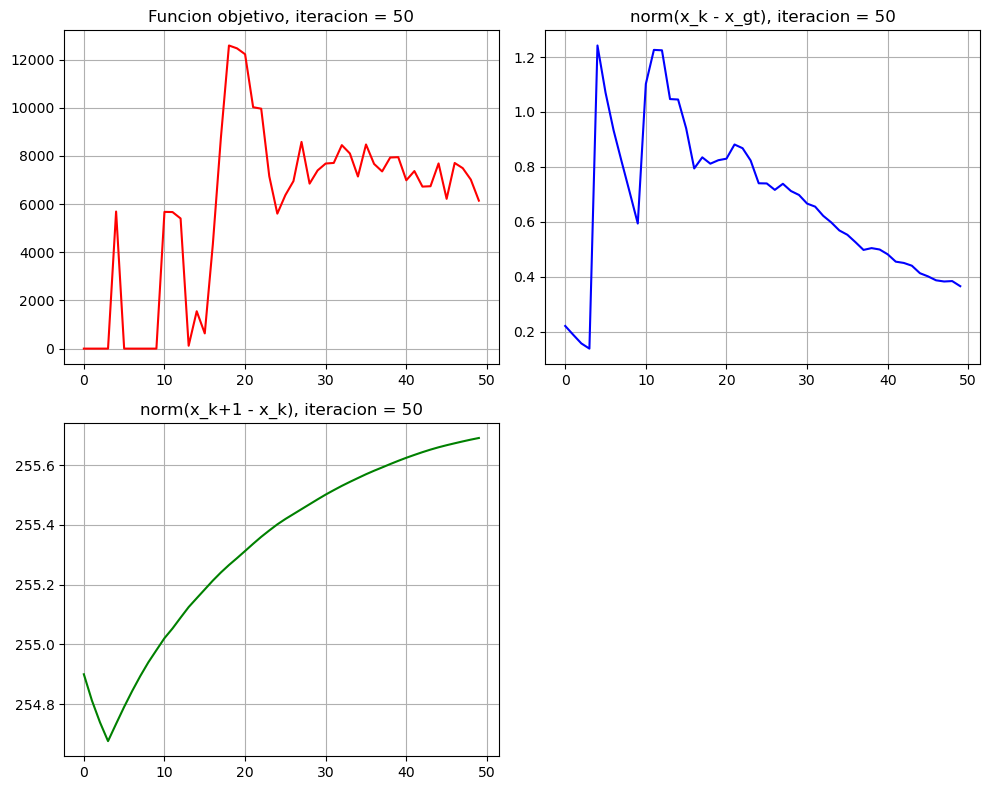

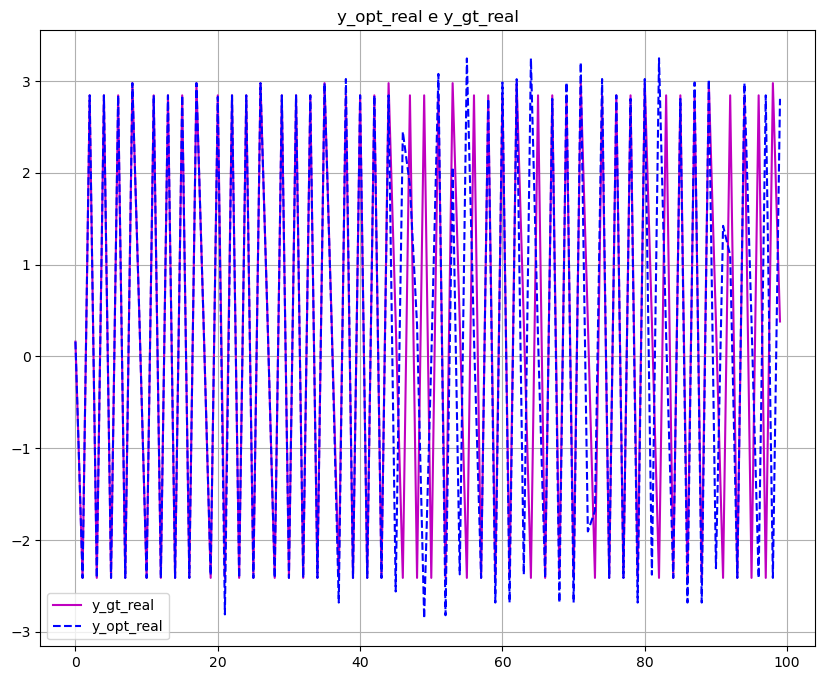

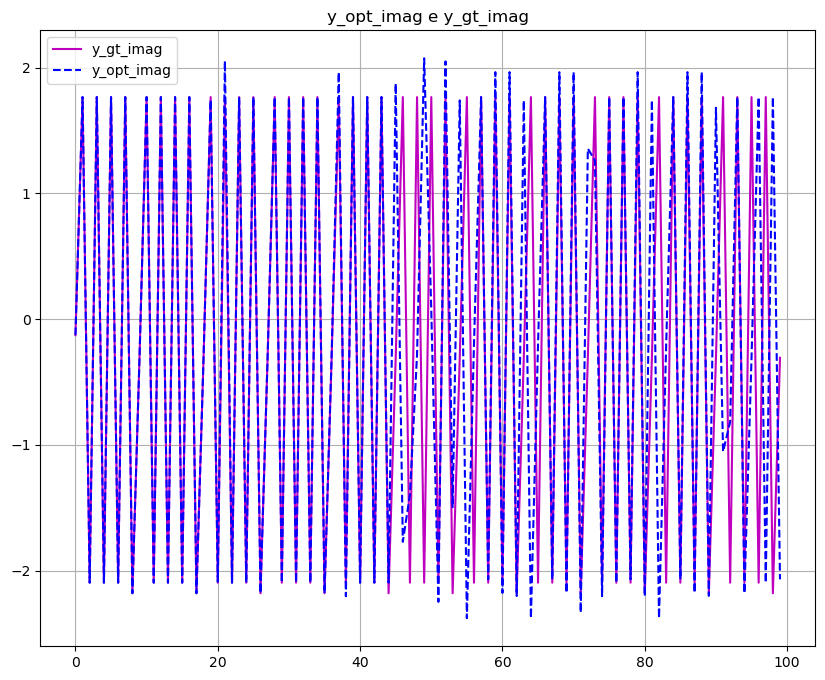

-----------
k: 50
loss = 6050.193359375
diff_x_gt: 255.6906713635013
diff_x: 255.695958288785
-----------
k: 51
loss = 7283.28466796875
diff_x_gt: 255.695958288785
diff_x: 255.70088427611824
-----------
k: 52
loss = 7197.92724609375
diff_x_gt: 255.70088427611824
diff_x: 255.7056314123309
-----------
k: 53
loss = 7940.6806640625
diff_x_gt: 255.7056314123309
diff_x: 255.71018260577983
-----------
k: 54
loss = 8482.677734375
diff_x_gt: 255.71018260577983
diff_x: 255.71475380111266
-----------
k: 55
loss = 7611.19384765625
diff_x_gt: 255.71475380111266
diff_x: 255.71920113733844
-----------
k: 56
loss = 8090.20849609375
diff_x_gt: 255.71920113733844
diff_x: 255.7231245976638
-----------
k: 57
loss = 7527.12841796875
diff_x_gt: 255.7231245976638
diff_x: 255.7269052848754
-----------
k: 58
loss = 7330.16552734375
diff_x_gt: 255.7269052848754
diff_x: 255.73041450822512
-----------
k: 59
loss = 7491.88037109375
diff_x_gt: 255.73041450822512
diff_x: 255.73346598141697
-----------
k: 60
loss = 6

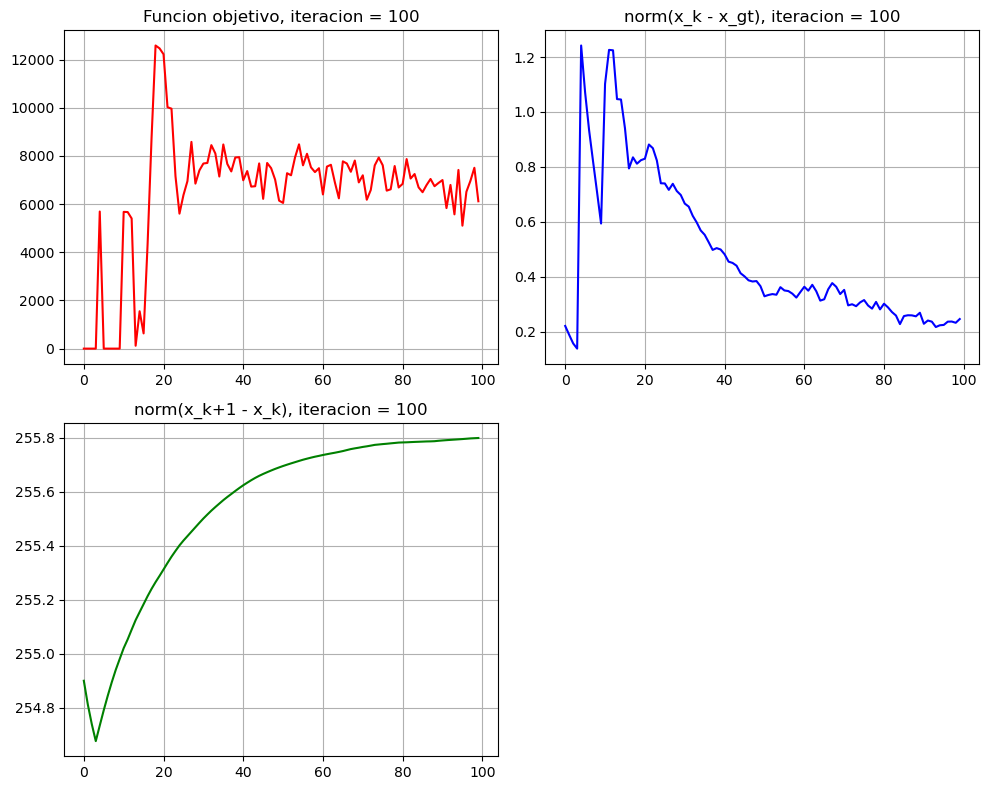

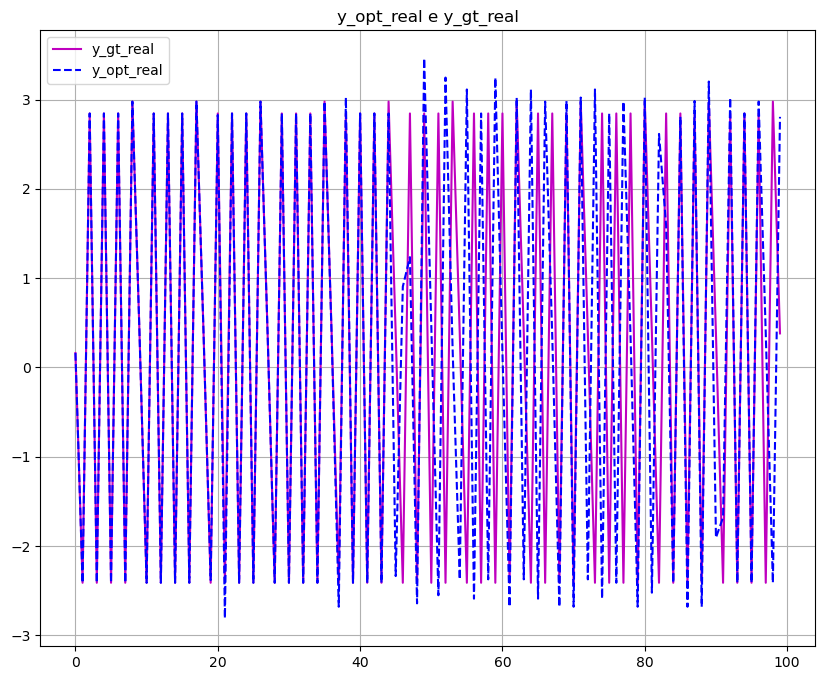

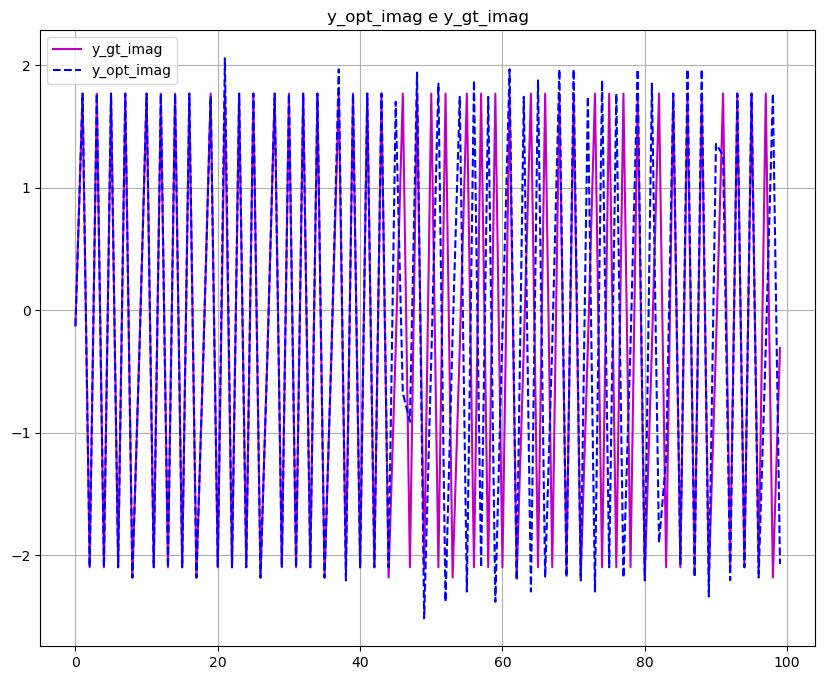

-----------
k: 100
loss = 6115.95556640625
diff_x_gt: 255.79975257513786
diff_x: 255.80065081975673
-----------
k: 101
loss = 6482.90966796875
diff_x_gt: 255.80065081975673
diff_x: 255.80170866781205
-----------
k: 102
loss = 5548.72119140625
diff_x_gt: 255.80170866781205
diff_x: 255.80305792875728
-----------
k: 103
loss = 5555.19287109375
diff_x_gt: 255.80305792875728
diff_x: 255.804672806619
-----------
k: 104
loss = 6896.73291015625
diff_x_gt: 255.804672806619
diff_x: 255.80611696169802
-----------
k: 105
loss = 7077.49560546875
diff_x_gt: 255.80611696169802
diff_x: 255.80755387506895
-----------
k: 106
loss = 6565.56787109375
diff_x_gt: 255.80755387506895
diff_x: 255.80892031370593
-----------
k: 107
loss = 7345.9423828125
diff_x_gt: 255.80892031370593
diff_x: 255.81050221682287
-----------
k: 108
loss = 6352.69384765625
diff_x_gt: 255.81050221682287
diff_x: 255.81211185634672
-----------
k: 109
loss = 5689.10009765625
diff_x_gt: 255.81211185634672
diff_x: 255.8132829886786
------

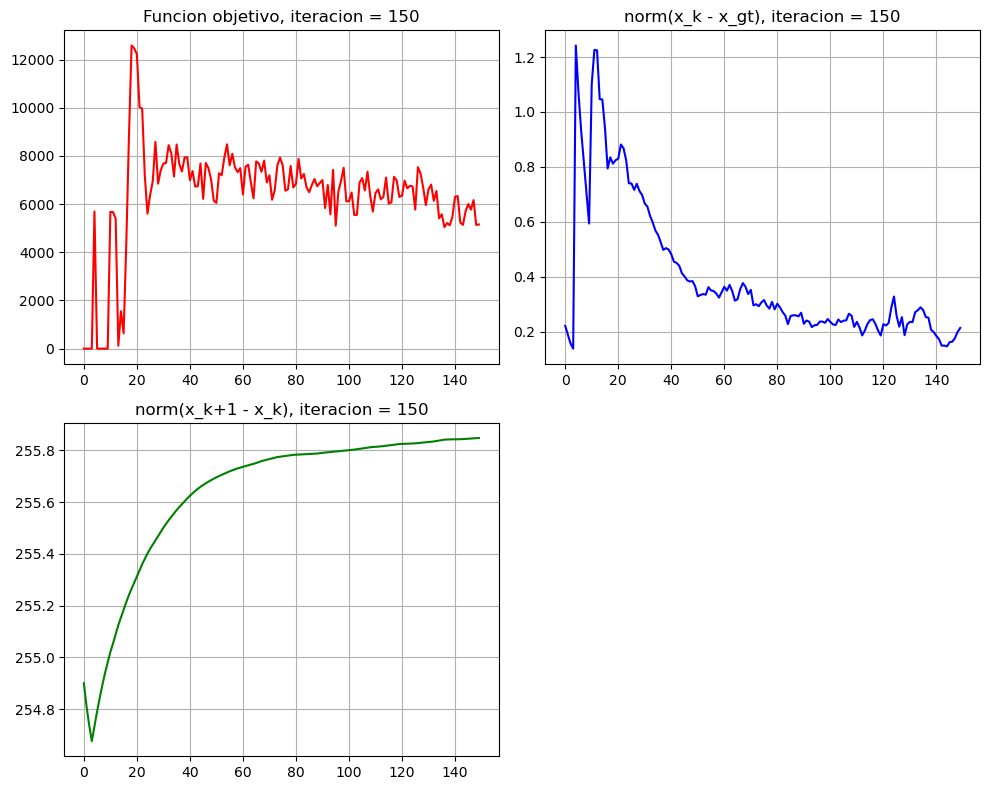

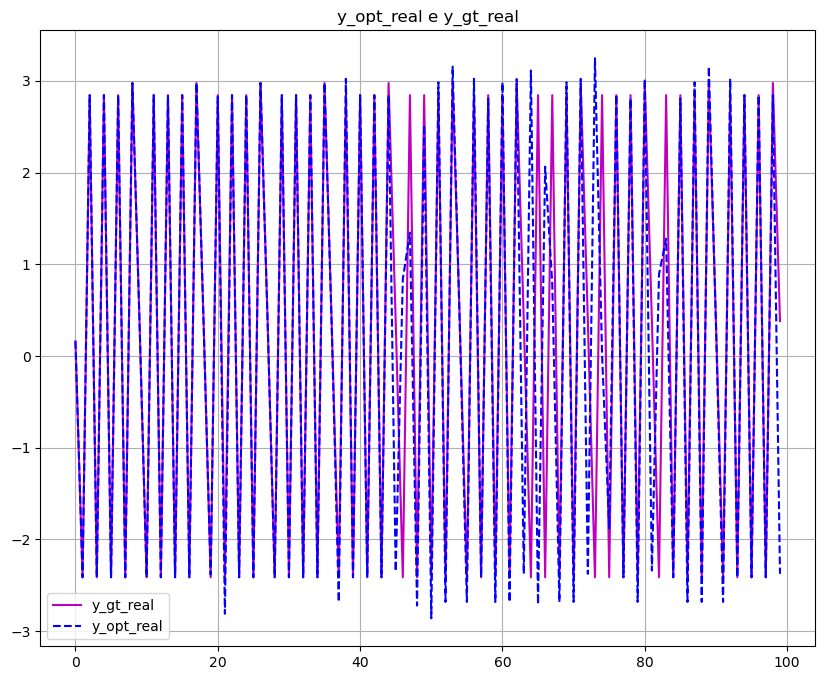

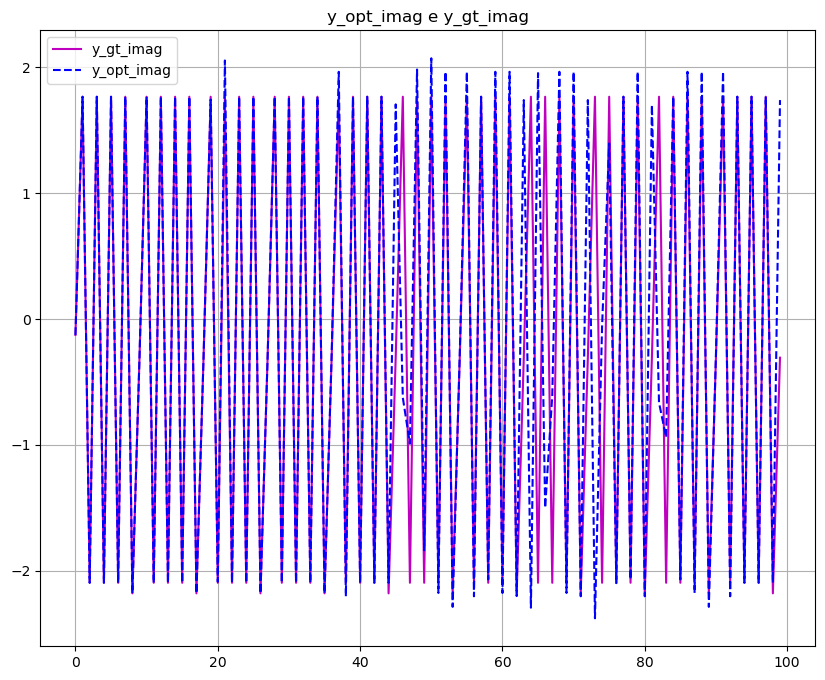

-----------
k: 150
loss = 5616.49560546875
diff_x_gt: 255.84799268126184
diff_x: 255.84944700046609
-----------
k: 151
loss = 6328.00146484375
diff_x_gt: 255.84944700046609
diff_x: 255.85082316768384
-----------
k: 152
loss = 5012.1220703125
diff_x_gt: 255.85082316768384
diff_x: 255.85212881868435
-----------
k: 153
loss = 5661.74609375
diff_x_gt: 255.85212881868435
diff_x: 255.8533634146071
-----------
k: 154
loss = 6001.55126953125
diff_x_gt: 255.8533634146071
diff_x: 255.85455423789418
-----------
k: 155
loss = 6088.9736328125
diff_x_gt: 255.85455423789418
diff_x: 255.8555922034936
-----------
k: 156
loss = 6534.70166015625
diff_x_gt: 255.8555922034936
diff_x: 255.8565214556687
-----------
k: 157
loss = 6162.662109375
diff_x_gt: 255.8565214556687
diff_x: 255.85714326109806
-----------
k: 158
loss = 4942.9462890625
diff_x_gt: 255.85714326109806
diff_x: 255.85843890703208
-----------
k: 159
loss = 6217.85791015625
diff_x_gt: 255.85843890703208
diff_x: 255.85906805224997
-----------
k:

KeyboardInterrupt: 

In [131]:
x_img = np.zeros((600,800))
x_opt = torch.tensor(x_img[10,:])
x_opt[20] = 255

x_opt = optimizacion_sin_reg(x_img, x_opt, max_iter = 500, eps = 1e-4, lr = 0.1)

In [ ]:
x_img = np.zeros((600,800))

x_gt = torch.tensor(x_img[10,:])
y_gt = T_linea(x_img.shape[0], x_img.shape[1], x_gt)

diff_x = torch.inf
diff_x_record = []
loss_record = []
max_iter = 100
eps = 1e-4
lr = 0.1

x_opt = x_gt.clone()
x_opt[740] = 255

x_opt.requires_grad = True
optimizer = torch.optim.Adam([x_opt], lr=lr)

k = 0

while (k < max_iter) and (diff_x > eps):

    print('k: {}'.format(k))

    x_ant = x_opt.detach().clone()

    optimizer.zero_grad()
    loss = actualizacion_fila_x(x_img.shape[0], x_img.shape[1], x_opt, y_gt)
    
    print('loss = {}'.format(loss))

    loss.backward(retain_graph=True)
    optimizer.step()
    
    loss_record.append(loss.detach())
    x_next = x_opt.detach().clone()

    diff_x = torch.norm(x_next - x_ant)
    diff_x_record.append(diff_x)
    print('diff_x: {}'.format(diff_x))

    k = k + 1

    diff_x = torch.norm(x_next - x_ant)

    print('-----------')

print("\nTermino!")

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1) 
plt.plot(loss_record, 'r')
plt.title('Funcion objetivo')


plt.subplot(1, 2, 2)  
plt.plot(diff_x_record, 'b') 
plt.title('norm(x_{k+1} -x_k)')

plt.tight_layout()

plt.show()

## Objective Function: norm(y - T(x))^2 + lambda*R(x).

### Prueba formando imagen con linea del vamoo

In [ ]:
lam = 10
tv = TotalVariation()

def TV(x):
    x = x.unsqueeze(0).unsqueeze(0)
    return lam * tv(x)

def L1(x, eps=1e-5):
    resu = torch.sum(torch.square(x))
    return lam * (resu + eps)**(1/2)

def L2(x):
    return lam * torch.norm(x, p=2)**2

In [ ]:
def actualizacion_fila_x_regu(x_filas, x_columnas, x_linea, y):
    return torch.norm(y - T_linea(x_filas, x_columnas, x_linea))**2 + lam * L2(x_linea)

In [ ]:
x_img = torch.tensor(imread(os.path.join("./imagenes", "VAMO.png"), as_gray=True))
#x_img = np.zeros((600,800))
x_gt = torch.tensor(x_img[10,:])

y_gt = T_linea(x_img.shape[0], x_img.shape[1], x_gt)

diff_x = torch.inf
max_iter = 500
diff_x_record = []
loss_record = []
eps = 1e-6
lr = 0.01

x_opt = torch.ones_like(x_gt, requires_grad = False)
x_opt = x_opt
x_opt.requires_grad = True
optimizer = torch.optim.Adam([x_opt], lr=lr)

k = 0

while (k < max_iter) and (diff_x > eps):

    print('k: {}'.format(k))

    x_ant = x_opt.detach().clone()

    optimizer.zero_grad()
    loss = actualizacion_fila_x_regu(x_img.shape[0], x_img.shape[1], x_opt, y_gt)
    print('loss = {}'.format(loss))

    loss.backward(retain_graph=True)
    optimizer.step()

    loss_record.append(loss.detach())
    x_next = x_gt.detach().clone()

    diff_x = torch.norm(x_next - x_ant)
    print('diff_x: {}'.format(diff_x))

    k = k + 1
    
    diff_x_record.append(diff_x)
    diff_x = torch.norm(x_next - x_ant)

    print('-----------')

print("\nTermino!")

print('lambda vale: {}'.format(lam))
print('lr vale: {}'.format(lr))

#print('x_true vale:')
#print(x_img[10,200:211])

#print('x optimo vale:')
#x_next_norm = (x_next - x_next.min())/(x_next.max() - x_next.min())
#print(x_next_norm[200:211])

#y_pred = T_linea(x_img.shape[0], x_img.shape[1], x_next)
#diferencia = y - y_pred

#print('la diferencia entre y e y_pred = T(x_optimo) vale:')
#print(diferencia[:15])

#print('y vale:')
#print(y[200:211])

#print('y_pred vale:')
#print(y_pred[200:211])

#y_obs_total = x_img.clone()
#y_obs_total.to(torch.complex64)

#y_pred_total = x_img.clone()
#y_pred_total.to(torch.complex64)

#cant_filas = x_img.shape[0]
#for i in range(cant_filas):
#    y_pred_total[i,:] = y_pred
#    y_obs_total[i,:] = y

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1) 
plt.plot(loss_record, 'r')
plt.title('Funcion objetivo')


plt.subplot(1, 2, 2)  
plt.plot(diff_x_record, 'b') 
plt.title('norm(x_{k+1} -x_k)')

plt.tight_layout()

plt.show()

In [ ]:
###tomo modulo

y_pred_total_mod = y_pred_total.abs()
y_obs_total_mod = y_obs_total.abs()

y_pred_total_mod = (y_pred_total - y_pred_total.min())/(y_pred_total.max() - y_pred_total.min())
y_obs_total_mod = (y_obs_total - y_obs_total.min())/(y_obs_total.max() - y_obs_total.min())

plt.imshow(y_pred_total_mod.detach(), cmap = 'gray')
plt.title('modulo y_pred')
plt.show()

plt.imshow(y_obs_total_mod.detach(), cmap = 'gray')
plt.title('modulo y_obs')
plt.show()

In [ ]:
img_save = torch.zeros((filas, columnas,3))

img_real = img_salida.real
img_imag = img_salida.imag

max_value_real = img_real.max()
min_value_real = img_real.min()
max_value_imag = img_imag.max()
min_value_imag = img_imag.min()

img_real_normalizado = (img_real - min_value_real)/(max_value_real - min_value_real)
img_imag_normalizado = (img_imag - min_value_imag)/(max_value_imag - min_value_imag)

img_save[:,:,0] = img_real_normalizado
img_save[:,:,1] = img_imag_normalizado

### Prueba formando imagen con linea del ceros

In [ ]:
lam = 50
tv = TotalVariation()

def TV(x):
    x = x.unsqueeze(0).unsqueeze(0)
    return lam * tv(x)

def L1(x, eps=1e-5):
    resu = torch.sum(torch.square(x))
    return lam * (resu + eps)**(1/2)

def L2(x):
    return lam * torch.norm(x, p=2)**2

def actualizacion_fila_x_regu(x_filas, x_columnas, x_linea, y):
    return torch.norm(y - T_linea(x_filas, x_columnas, x_linea))**2 + lam * L2(x_linea)

#x_img = torch.tensor(imread(os.path.join("./imagenes", "VAMO.png"), as_gray=True))
x_img = torch.zeros((600,800))
x_gt = torch.tensor(x_img[10,:])

y_gt = T_linea(x_img.shape[0], x_img.shape[1], x_gt)

diff_x = torch.inf
diff_x_record = []
loss_record = []
max_iter = 500
eps = 1e-6
lr = 0.1

x_opt = torch.ones_like(x_gt, requires_grad = False)
x_opt = x_opt
x_opt.requires_grad = True
optimizer = torch.optim.Adam([x_opt], lr=lr)

k = 0

while (k < max_iter) and (diff_x > eps):

    print('k: {}'.format(k))

    x_ant = x_opt.detach().clone()

    optimizer.zero_grad()
    loss = actualizacion_fila_x_regu(x_img.shape[0], x_img.shape[1], x_opt, y_gt)
    print('loss = {}'.format(loss))

    loss.backward(retain_graph=True)
    optimizer.step()
    
    loss_record.append(loss.detach())

    x_next = x_opt.detach().clone()

    diff_x = torch.norm(x_next - x_ant)
    diff_x_record.append(diff_x)

    print('diff_x: {}'.format(diff_x))

    k = k + 1

    diff_x = torch.norm(x_next - x_ant)

    print('-----------')

print("\nTermino!")

print('lambda vale: {}'.format(lam))
print('lr vale: {}'.format(lr))

#print('x_true vale:')
#print(x_img[10,200:211])

#print('x optimo vale:')
#x_next_norm = (x_next - x_next.min())/(x_next.max() - x_next.min())
#print(x_next_norm[200:211])

#y_pred = T_linea(x_img.shape[0], x_img.shape[1], x_next)
#diferencia = y - y_pred

#print('la diferencia entre y e y_pred = T(x_optimo) vale:')
#print(diferencia[:15])

#print('y vale:')
#print(y[200:211])

#print('y_pred vale:')
#print(y_pred[200:211])

#y_obs_total = x_img.clone()
#y_obs_total.to(torch.complex64)

#y_pred_total = x_img.clone()
#y_pred_total.to(torch.complex64)

#cant_filas = x_img.shape[0]
#for i in range(cant_filas):
#    y_pred_total[i,:] = y_pred
#    y_obs_total[i,:] = y

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1) 
plt.plot(loss_record, 'r')
plt.title('Funcion objetivo. lambda = {}'.format(lam))


plt.subplot(1, 2, 2)  
plt.plot(diff_x_record, 'b') 
plt.title('norm(x_{k+1} -x_k)')

plt.tight_layout()

plt.show()

In [ ]:
lam = 10
tv = TotalVariation()

def TV(x):
    x = x.unsqueeze(0).unsqueeze(0)
    return lam * tv(x)

def L1(x, eps=1e-5):
    resu = torch.sum(torch.square(x))
    return lam * (resu + eps)**(1/2)

def L2(x):
    return lam * torch.norm(x, p=2)**2

def actualizacion_fila_x_regu(x_filas, x_columnas, x_linea, y):
    return torch.norm(y - T_linea(x_filas, x_columnas, x_linea))**2 + lam * L2(x_linea)

#x_img = torch.tensor(imread(os.path.join("./imagenes", "VAMO.png"), as_gray=True))
x_img = torch.zeros((600,800))
x_gt = torch.tensor(x_img[10,:])

y_gt = T_linea(x_img.shape[0], x_img.shape[1], x_gt)

diff_x = torch.inf
diff_x_record = []
loss_record = []
max_iter = 500
eps = 1e-6
lr = 0.1

x_opt = torch.ones_like(x_gt, requires_grad = False)
x_opt = x_opt
x_opt.requires_grad = True
optimizer = torch.optim.Adam([x_opt], lr=lr)

k = 0

while (k < max_iter) and (diff_x > eps):

    print('k: {}'.format(k))

    x_ant = x_opt.detach().clone()

    optimizer.zero_grad()
    loss = actualizacion_fila_x_regu(x_img.shape[0], x_img.shape[1], x_opt, y_gt)
    print('loss = {}'.format(loss))

    loss.backward(retain_graph=True)
    optimizer.step()
    
    loss_record.append(loss.detach())

    x_next = x_opt.detach().clone()

    diff_x = torch.norm(x_next - x_ant)
    diff_x_record.append(diff_x)

    print('diff_x: {}'.format(diff_x))

    k = k + 1

    diff_x = torch.norm(x_next - x_ant)

    print('-----------')

print("\nTermino!")

print('lambda vale: {}'.format(lam))
print('lr vale: {}'.format(lr))

#print('x_true vale:')
#print(x_img[10,200:211])

#print('x optimo vale:')
#x_next_norm = (x_next - x_next.min())/(x_next.max() - x_next.min())
#print(x_next_norm[200:211])

#y_pred = T_linea(x_img.shape[0], x_img.shape[1], x_next)
#diferencia = y - y_pred

#print('la diferencia entre y e y_pred = T(x_optimo) vale:')
#print(diferencia[:15])

#print('y vale:')
#print(y[200:211])

#print('y_pred vale:')
#print(y_pred[200:211])

#y_obs_total = x_img.clone()
#y_obs_total.to(torch.complex64)

#y_pred_total = x_img.clone()
#y_pred_total.to(torch.complex64)

#cant_filas = x_img.shape[0]
#for i in range(cant_filas):
#    y_pred_total[i,:] = y_pred
#    y_obs_total[i,:] = y

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1) 
plt.plot(loss_record, 'r')
plt.title('Funcion objetivo. lambda = {}'.format(lam))


plt.subplot(1, 2, 2)  
plt.plot(diff_x_record, 'b') 
plt.title('norm(x_{k+1} -x_k)')

plt.tight_layout()

plt.show()

In [ ]:
x_img = torch.zeros((600,800))
x_gt = torch.tensor(x_img[10,:])

y_gt = T_linea(x_img.shape[0], x_img.shape[1], x_gt)

diff_x = torch.inf
diff_x_record = []
loss_record = []
max_iter = 500
eps = 1e-6
lr = 0.1

x_opt = torch.ones_like(x_gt, requires_grad = False)
x_opt = x_opt
x_opt.requires_grad = True
optimizer = torch.optim.Adam([x_opt], lr=lr)

print(torch.norm(y_gt - T_linea(x_img.shape[0], x_img.shape[1], x_opt))**2)

In [ ]:
lam = 20
tv = TotalVariation()

def TV(x):
    x = x.unsqueeze(0).unsqueeze(0)
    return lam * tv(x)

def L1(x, eps=1e-5):
    resu = torch.sum(torch.square(x))
    return lam * (resu + eps)**(1/2)

def L2(x):
    return lam * torch.norm(x, p=2)**2

def actualizacion_fila_x_regu(x_filas, x_columnas, x_linea, y):
    return torch.norm(y - T_linea(x_filas, x_columnas, x_linea))**2 + lam * L2(x_linea)

#x_img = torch.tensor(imread(os.path.join("./imagenes", "VAMO.png"), as_gray=True))
x_img = torch.zeros((600,800))
x_gt = torch.tensor(x_img[10,:])

y_gt = T_linea(x_img.shape[0], x_img.shape[1], x_gt)

diff_x = torch.inf
diff_x_record = []
loss_record = []
max_iter = 500
eps = 1e-6
lr = 0.1

x_opt = torch.ones_like(x_gt, requires_grad = False)
x_opt = x_opt
x_opt.requires_grad = True
optimizer = torch.optim.Adam([x_opt], lr=lr)

k = 0

while (k < max_iter) and (diff_x > eps):

    print('k: {}'.format(k))

    x_ant = x_opt.detach().clone()

    optimizer.zero_grad()
    loss = actualizacion_fila_x_regu(x_img.shape[0], x_img.shape[1], x_opt, y_gt)
    print('loss = {}'.format(loss))

    loss.backward(retain_graph=True)
    optimizer.step()
    
    loss_record.append(loss.detach())

    x_next = x_opt.detach().clone()

    diff_x = torch.norm(x_next - x_ant)
    diff_x_record.append(diff_x)

    print('diff_x: {}'.format(diff_x))

    k = k + 1

    diff_x = torch.norm(x_next - x_ant)

    print('-----------')

print("\nTermino!")

print('lambda vale: {}'.format(lam))
print('lr vale: {}'.format(lr))

#print('x_true vale:')
#print(x_img[10,200:211])

#print('x optimo vale:')
#x_next_norm = (x_next - x_next.min())/(x_next.max() - x_next.min())
#print(x_next_norm[200:211])

#y_pred = T_linea(x_img.shape[0], x_img.shape[1], x_next)
#diferencia = y - y_pred

#print('la diferencia entre y e y_pred = T(x_optimo) vale:')
#print(diferencia[:15])

#print('y vale:')
#print(y[200:211])

#print('y_pred vale:')
#print(y_pred[200:211])

#y_obs_total = x_img.clone()
#y_obs_total.to(torch.complex64)

#y_pred_total = x_img.clone()
#y_pred_total.to(torch.complex64)

#cant_filas = x_img.shape[0]
#for i in range(cant_filas):
#    y_pred_total[i,:] = y_pred
#    y_obs_total[i,:] = y

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1) 
plt.plot(loss_record, 'r')
plt.title('Funcion objetivo. lambda = {}'.format(lam))


plt.subplot(1, 2, 2)  
plt.plot(diff_x_record, 'b') 
plt.title('norm(x_{k+1} -x_k)')

plt.tight_layout()

plt.show()

In [ ]:
lam = 10
tv = TotalVariation()

def TV(x):
    x = x.unsqueeze(0).unsqueeze(0)
    return lam * tv(x)

def L1(x, eps=1e-5):
    resu = torch.sum(torch.square(x))
    return lam * (resu + eps)**(1/2)

def L2(x):
    return lam * torch.norm(x, p=2)**2

def actualizacion_fila_x_regu(x_filas, x_columnas, x_linea, y):
    return torch.norm(y - T_linea(x_filas, x_columnas, x_linea))**2 + lam * L2(x_linea)

#x_img = torch.tensor(imread(os.path.join("./imagenes", "VAMO.png"), as_gray=True))
x_img = torch.ones((600,800))
x_gt = torch.tensor(x_img[10,:])

y_gt = T_linea(x_img.shape[0], x_img.shape[1], x_gt)

diff_x = torch.inf
diff_x_record = []
loss_record = []
max_iter = 500
eps = 1e-6
lr = 0.1

x_opt = torch.zeros_like(x_gt, requires_grad = False)
x_opt = x_opt
x_opt.requires_grad = True
optimizer = torch.optim.Adam([x_opt], lr=lr)

k = 0

while (k < max_iter) and (diff_x > eps):

    print('k: {}'.format(k))

    x_ant = x_opt.detach().clone()

    optimizer.zero_grad()
    loss = actualizacion_fila_x_regu(x_img.shape[0], x_img.shape[1], x_opt, y_gt)
    print('loss = {}'.format(loss))

    loss.backward(retain_graph=True)
    optimizer.step()
    
    loss_record.append(loss.detach())

    x_next = x_opt.detach().clone()

    diff_x = torch.norm(x_next - x_ant)
    diff_x_record.append(diff_x)

    print('diff_x: {}'.format(diff_x))

    k = k + 1

    diff_x = torch.norm(x_next - x_ant)

    print('-----------')

print("\nTermino!")

print('lambda vale: {}'.format(lam))
print('lr vale: {}'.format(lr))

#print('x_true vale:')
#print(x_img[10,200:211])

#print('x optimo vale:')
#x_next_norm = (x_next - x_next.min())/(x_next.max() - x_next.min())
#print(x_next_norm[200:211])

#y_pred = T_linea(x_img.shape[0], x_img.shape[1], x_next)
#diferencia = y - y_pred

#print('la diferencia entre y e y_pred = T(x_optimo) vale:')
#print(diferencia[:15])

#print('y vale:')
#print(y[200:211])

#print('y_pred vale:')
#print(y_pred[200:211])

#y_obs_total = x_img.clone()
#y_obs_total.to(torch.complex64)

#y_pred_total = x_img.clone()
#y_pred_total.to(torch.complex64)

#cant_filas = x_img.shape[0]
#for i in range(cant_filas):
#    y_pred_total[i,:] = y_pred
#    y_obs_total[i,:] = y

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1) 
plt.plot(loss_record, 'r')
plt.title('Funcion objetivo. lambda = {}'.format(lam))


plt.subplot(1, 2, 2)  
plt.plot(diff_x_record, 'b') 
plt.title('norm(x_{k+1} -x_k)')

plt.tight_layout()

plt.show()

In [ ]:
x_img = torch.ones((600,800))
x_gt = torch.tensor(x_img[10,:])

y_gt = T_linea(x_img.shape[0], x_img.shape[1], x_gt)

diff_x = torch.inf
diff_x_record = []
loss_record = []
max_iter = 500
eps = 1e-6
lr = 0.1

x_opt = torch.zeros_like(x_gt, requires_grad = False)
x_opt = x_opt
x_opt.requires_grad = True
optimizer = torch.optim.Adam([x_opt], lr=lr)

print(torch.norm(y_gt - T_linea(x_img.shape[0], x_img.shape[1], x_opt))**2)

le agrego AWGN a la condicion inicial (x_inicial = x_gt + ruido)

In [ ]:
lam = 10
tv = TotalVariation()

def TV(x):
    x = x.unsqueeze(0).unsqueeze(0)
    return lam * tv(x)

def L1(x, eps=1e-5):
    resu = torch.sum(torch.square(x))
    return lam * (resu + eps)**(1/2)

def L2(x):
    return lam * torch.norm(x, p=2)**2

def actualizacion_fila_x_regu(x_filas, x_columnas, x_linea, y):
    return torch.norm(y - T_linea(x_filas, x_columnas, x_linea))**2 + lam * L2(x_linea)

x_img = torch.ones((600,800))
noise = 5* torch.randn((x_img.shape[0], x_img.shape[1]))
x_img = x_img + noise
x_gt = torch.tensor(x_img[10,:])

y_gt = T_linea(x_img.shape[0], x_img.shape[1], x_gt)

diff_x = torch.inf
diff_x_record = []
loss_record = []
max_iter = 500
eps = 1e-6
lr = 0.1

x_opt = torch.zeros_like(x_gt, requires_grad = False)
x_opt = x_opt
x_opt.requires_grad = True
optimizer = torch.optim.Adam([x_opt], lr=lr)

k = 0

while (k < max_iter) and (diff_x > eps):

    print('k: {}'.format(k))

    x_ant = x_opt.detach().clone()

    optimizer.zero_grad()
    loss = actualizacion_fila_x_regu(x_img.shape[0], x_img.shape[1], x_opt, y_gt)
    print('loss = {}'.format(loss))

    loss.backward(retain_graph=True)
    optimizer.step()
    
    loss_record.append(loss.detach())

    x_next = x_opt.detach().clone()

    diff_x = torch.norm(x_next - x_ant)
    diff_x_record.append(diff_x)

    print('diff_x: {}'.format(diff_x))

    k = k + 1

    diff_x = torch.norm(x_next - x_ant)

    print('-----------')

print("\nTermino!")

print('lambda vale: {}'.format(lam))
print('lr vale: {}'.format(lr))

#print('x_true vale:')
#print(x_img[10,200:211])

#print('x optimo vale:')
#x_next_norm = (x_next - x_next.min())/(x_next.max() - x_next.min())
#print(x_next_norm[200:211])

#y_pred = T_linea(x_img.shape[0], x_img.shape[1], x_next)
#diferencia = y - y_pred

#print('la diferencia entre y e y_pred = T(x_optimo) vale:')
#print(diferencia[:15])

#print('y vale:')
#print(y[200:211])

#print('y_pred vale:')
#print(y_pred[200:211])

#y_obs_total = x_img.clone()
#y_obs_total.to(torch.complex64)

#y_pred_total = x_img.clone()
#y_pred_total.to(torch.complex64)

#cant_filas = x_img.shape[0]
#for i in range(cant_filas):
#    y_pred_total[i,:] = y_pred
#    y_obs_total[i,:] = y

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1) 
plt.plot(loss_record, 'r')
plt.title('Funcion objetivo. lambda = {}'.format(lam))


plt.subplot(1, 2, 2)  
plt.plot(diff_x_record, 'b') 
plt.title('norm(x_{k+1} -x_k)')

plt.tight_layout()

plt.show()

In [ ]:
###tomo modulo

y_pred_total_mod = y_pred_total.abs()
y_obs_total_mod = y_obs_total.abs()

y_pred_total_mod = (y_pred_total - y_pred_total.min())/(y_pred_total.max() - y_pred_total.min())
y_obs_total_mod = (y_obs_total - y_obs_total.min())/(y_obs_total.max() - y_obs_total.min())

plt.imshow(y_pred_total_mod.detach(), cmap = 'gray')
plt.title('modulo y_pred')
plt.show()

plt.imshow(y_obs_total_mod.detach(), cmap = 'gray')
plt.title('modulo y_obs')
plt.show()

## Comparo con resultados de timag

In [ ]:
from degradacionT_timag.degradacion_linea import *

In [ ]:
x_img = np.zeros((600,800))
x = torch.tensor(x_img[10,:])
T_timag = forward(x_img.shape[0], x_img.shape[1], x)

In [ ]:
x_img = np.zeros((600,800))
x = torch.tensor(x_img[10,:])

y = T_linea(x_img.shape[0], x_img.shape[1], x)

diff_x = torch.inf
max_iter = 10
eps = 1e-4
lr = 0.1

x = torch.ones_like(x, requires_grad = True)
optimizer = torch.optim.Adam([x], lr=lr)

k = 0

while (k < max_iter) and (diff_x > eps):

    print('k: {}'.format(k))

    x_ant = x.detach().clone()

    optimizer.zero_grad()
    loss = actualizacion_fila_x(x_img.shape[0], x_img.shape[1], x, y)
    print('loss = {}'.format(loss))

    loss.backward(retain_graph=True)
    optimizer.step()

    x_next = x.detach().clone()

    diff_x = torch.norm(x_next - x_ant)
    print('diff_x: {}'.format(diff_x))

    k = k + 1

    # Recalculo diferencia entre actualizaciones
    diff_x = torch.norm(x_next - x_ant)

    # Asigno la actualizacion
    x = x_next.clone()

    print('-----------')

print("\nTermino!")

In [ ]:
### INICIALIZO VARIABLES ###

mu = 1
sigma2 = 1

diff_x = torch.inf

cant_filas = x_real.shape[0]

###SE VA TRABAJAR CON SOLO UNA LINEA. SE ELIJE LA LINEA 200. SE APILA LA DEGRADACION DE ESA LINEA VARIAS VECES PARA FORMAR IMAGEN y_img###
y_img = x_real.clone()
cant_filas = x_real.shape[0]
fila_200 = T_linea(x_real.shape[0], x_real.shape[1], x_real[200,:])
for i in range(cant_filas):
    y_img[i,:] = fila_200
#x y z se inicializan iguales a y_img
x = uint2tensor4(y_img.clone().detach().numpy())
z = x.clone()
z = uint2tensor4(y_img.clone().detach().numpy())
x_sig_img = x.clone()
x_sig_uint = y_img.clone()
y = y_img[200,:]

### TERMINO DE INICIALIZAR VARIABLES ###

x_filas = x.shape[2]
x_columnas = x.shape[3]

for iter in range(iter_num):
    print(f"Iteracion: {iter}/{iter_num}", end="\r", flush=True)
    print(f"\ndiff_x: {diff_x}")
    
    fila_i_esima = x[0,0,200,:].clone().detach().requires_grad_(True)
    def actualizacion_fila_x(x_filas, x_columnas, x_param_linea):
        return torch.norm(y - T_linea(x_filas, x_columnas, x_param_linea))**2 + mu*sigma2*torch.norm(x_param_linea - z[0,0,200,:])**2
    # Actualizacion de x
    x_opt = minimizeViaTorch(actualizacion_fila_x, x0=fila_i_esima, x_filas = x_filas, x_columnas = x_columnas, lr=1e-4, max_iter=10, eps=1e-5)

    for i in range(cant_filas):
        x_sig_uint[i,:] = x_opt

#PARA QUE CORRA MAS RAPIDO CORRERLO LO DE ARRIBA CON UNA LINEA Y DESPUES DUPLICAR HASTA FORMAR UNA IMAGEN

    x_sig_img = uint2tensor4(x_sig_uint.detach().numpy())

    # Actualizacion de z (.predict de red)
    x_sig_img = torch.cat((x_sig_img, sigmas[iter].float().repeat(1, 1, x_sig_img.shape[2], x_sig_img.shape[3])), dim=1)
    z_sig_img = model(x_sig_img)
    print(z_sig_img.shape)

    # Recalculo diferencia entre actualizaciones
    diff_x = torch.norm(x_sig_img - x)

    # Asigno la actualizacion
    x = x_sig_img.clone()
    z = z_sig_img.clone()

print("\nTermino!")

In [ ]:
plt.imshow(z[0,0,:,:],cmap = 'gray')

In [ ]:
x = normalize(x)
z = normalize(z)

In [ ]:
x = torch.where(x >= 0, x, 0)
x = torch.where(x <= 1, x, 1)

z = torch.where(z >= 0, z, 0)
z = torch.where(z <= 1, z, 1)

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(13,8))

axs[0].imshow(x_real, cmap="gray")
axs[0].set_title("Ground truth")

axs[1].imshow(y.detach(), cmap="gray")
axs[1].set_title("Degradacion")

axs[2].imshow(x.detach(), cmap="gray")
axs[2].set_title("x")

axs[3].imshow(z.detach(), cmap="gray")
axs[3].set_title("z")

plt.show()


#fig, axs = plt.subplots(1, 4, figsize=(13,8))

#axs[0].imshow(x_real, cmap="gray")
#axs[0].set_title("Ground truth")

#axs[1].imshow(1-y.detach(), cmap="gray")
#axs[1].set_title("Degradacion")

#axs[2].imshow(1-x.detach(), cmap="gray")
#axs[2].set_title("x")

#axs[3].imshow(1-z.detach(), cmap="gray")
#axs[3].set_title("z")

#plt.show()

In [ ]:
print("Ground truth:")
plt.figure(figsize=(10,8))
plt.imshow(x_real, cmap = 'gray')
plt.show()

print("Degradacion:")
plt.figure(figsize=(10,8))
plt.imshow(y.detach(), cmap = 'gray')
plt.show()

print("x:")
plt.figure(figsize=(10,8))
plt.imshow(x.detach(), cmap = 'gray')
plt.show()

print("z:")
plt.figure(figsize=(10,8))
plt.imshow(z.detach(), cmap = 'gray')
plt.show()

In [ ]:
print("x VS x_real")
print("="*30)

print(f"PSNR: {PSNR(x, x_real):0.4f} (PSNR ref.: {PSNR(x_real, x_real):0.4f})")
print(f"SSIM: {SSIM(x, x_real):0.4f}")
print(f"MS-SSIM: {MS_SSIM(x, x_real):0.4f}")
print(f"IW-SSIM: {IW_SSIM(x, x_real):0.4f}")

print()

print("y VS x_real")
print("="*30)

print(f"PSNR: {PSNR(y, x_real):0.4f} (PSNR ref.: {PSNR(x_real, x_real):0.4f})")
print(f"SSIM: {SSIM(y, x_real):0.4f}")
print(f"MS-SSIM: {MS_SSIM(y, x_real):0.4f}")
print(f"IW-SSIM: {IW_SSIM(y, x_real):0.4f}")

In [ ]:
imsave(f"./imagenes_restauradas/{img_file_name}", x.detach())

In [ ]:
import pandas as pd

In [ ]:
lams = [0, 0.5, 2, 5]
sigmas_energia = [0.01, 0.1, 1, 10]

df = pd.DataFrame(index=range(len(lams)*len(sigmas_energia)), columns=["lambda", "sigma", "PSNR", "SSIM", "MS-SSIM", "IW-SSIM"])

i = 0
for lam in lams:
    for sigma_energia in sigmas_energia:

        # Defino funciones con variables globales
        tv = TotalVariation()

        def f_energia(x):

            return (1/(2*sigma_energia**2)) * torch.norm(y - T_degradacion(x))**2

        def TV(x):

            x = x.unsqueeze(0).unsqueeze(0)

            return lam * tv(x)

        def L1(x):

            return lam * torch.norm(x, p=1)

        def L2(x):

            return lam * torch.norm(x, p=2)**2
        
        def grad_L2(x):

            return 2*lam*x

        def grad_L1(x):

            return lam * np.sign(x)

        def grad_TV(x, eps = 0.1):
            
            x = x.unsqueeze(0).unsqueeze(0)

            grad_x = image_gradients(x)

            norma_gradx = torch.norm(grad_x[0][0,0,:,:])
            norma_grady = torch.norm(grad_x[1][0,0,:,:])

            denominador = torch.sqrt(eps**2 + norma_gradx**2 + norma_grady**2).item()

            cociente_x = grad_x[0] / denominador
            cociente_y = grad_x[1] / denominador
            
            derivada_cociente_x = image_gradients(cociente_x)
            derivada_cociente_y = image_gradients(cociente_y)

            gradiente_tv = derivada_cociente_x[0][0,0,:,:] + derivada_cociente_y[1][0,0,:,:]

            return lam * gradiente_tv
        
        f = f_energia
        h = L2

        grad_h = grad_L2

        cte_h_lipz = 2*lam


        eps = 1e-6
        max_iter = 2_000

        Lz = round(cte_h_lipz + cte_h_lipz**2 + 3) + 1
        beta = max( cte_h_lipz + Lz + 2 , 3*(Lz**2 + cte_h_lipz**2)/((Lz + cte_h_lipz**2)/2) , 3*Lz**2) + 1
        Lx = round(beta + 6*cte_h_lipz**2 + 1) + 1

        diff_x = torch.inf
        diff_z = torch.inf
        diff_gamma = torch.inf

        #x = torch.zeros_like(x_real)
        #z = torch.ones_like(x_real)
        x = y.clone()
        z = x

        Nz = z.shape[0]

        gamma = torch.ones(x.shape)

        mat_inv = torch.from_numpy( np.linalg.inv(Lz + beta*np.identity(Nz)))


        nIter = 1

        while (nIter <= max_iter) and (max(diff_x, diff_z, diff_gamma) > eps):

            print(f"Iteracion: {nIter}/{max_iter}", end="\r", flush=True)
            
            if diff_x > 0:
                
                def actualizacion_x(x_param):

                    return f(x_param) + torch.sum(gamma * x_param) + (Lx/2) * torch.norm(x_param - x)**2 + torch.sum((x_param - x) * (beta*(x - z)))
            
                # Actualizacion de x
                x_sig = minimizeViaTorch(actualizacion_x, x0=x, lr=0.1, max_iter=1_000_000)

            # Actualizacion de z
            z_sig = mat_inv @ (Lz*z - grad_h(z) + gamma + beta*x_sig)
            
            # Actualizacion de gamma
            gamma_sig = gamma + beta*(x_sig - z_sig)

            # Recalculo diferencias entre actualizaciones
            diff_x = torch.norm(x_sig - x)
            diff_z = torch.norm(z_sig - z)
            diff_gamma = torch.norm(gamma_sig - gamma)

            # Asigno la actualizacion
            gamma = gamma_sig
            x = x_sig
            z = z_sig

            nIter += 1

        
        x = torch.where(x >= 0, x, 0)
        x = torch.where(x <= 1, x, 1)

        z = torch.where(z >= 0, z, 0)
        z = torch.where(z <= 1, z, 1)

        psnr_x = PSNR(x, x_real)
        ssim_x = SSIM(x, x_real)
        ms_ssim_x = MS_SSIM(x, x_real)
        iw_ssim_x = IW_SSIM(x, x_real)

        df.iloc[i,:] = [lam, sigma_energia, psnr_x, ssim_x, ms_ssim_x, iw_ssim_x]

        i += 1

In [ ]:
df.head(50)

In [ ]:
plt.figure(figsize=(12,8))

metrica = "IW-SSIM"

for i, sigma_energia in enumerate(sigmas_energia):
    
    df_aux = df.loc[ df.iloc[:,1]==sigma_energia ]
    plt.plot(df_aux.iloc[:,0], df_aux.loc[:,metrica], label=f"$\sigma$: {sigma_energia}")

plt.xlabel(f"$\lambda$")
plt.ylabel(metrica)
plt.grid()
plt.legend()
plt.title(f"Grid-search: {metrica}")
plt.show()